In [1]:
import pandas as pd
import re
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

#### Prepare & Load Data

In [33]:
### Load Data 
gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/variable_prompt_test_turbo.csv"
####gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/prompt_testing073123_v1.csv"
df_gpt3 = pd.read_csv(gpt3)

df_gpt3.shape

(4715, 8)

In [34]:
##check test runs
df_gpt3.groupby(['test','frame']).size()

test                                                                                               frame      
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']  gain_animal      3
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']                  gain_animal    102
                                                                                                   gain_forest    105
                                                                                                   gain_human      60
                                                                                                   loss_animal     74
                                                                                                                 ... 
['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']        loss_human       2
['combo 8D', 'system_message_1_json', 'user_message_6B2', 'inst

In [35]:
### Cleaning

#clean test names
df_gpt3['test'] = df_gpt3['test'].replace("['combo 7', 'system_message_1D', 'user_message_7']", "['combo 7', 'system_message_1B', 'user_message_7']")
##df_gpt3['test'] = df_gpt3['test'].replace("", "['combo 8C3', 'system_message_1C', 'user_message_4', 'instructions: task order & output']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4', 'system_message_4', 'user_message_4']", "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 3', 'system_message_1C', 'user_message_baseline1', 'human']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4B', 'system_message_4', 'user_message_5']", "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 9', 'system_message_1', 'user_message_5']", "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 5', 'system_message_baseline1', 'user_message_q1', 'q1 options']", "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8D', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']", "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']")


conditions1 = (df_gpt3['test'] == "['combo 8', 'system_message_1', 'user_message_4']") & (df_gpt3['temperature'] == .7)
df_gpt3.loc[conditions1, 'test'] = "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"

##beg prompt 
pattern = r'(.*?)\s*Scenario:'
df_gpt3['prompt_start'] = df_gpt3['prompt'].str.extract(pattern,  flags=re.DOTALL)
df_gpt3[['frame', 'scenario']] = df_gpt3['frame'].str.split('_', n=1, expand=True)


In [36]:
##drop  tests 
bad_tests = ["['combo 8C', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']",
 "['combo 6', 'system_message_1B', 'user_message_6']", 
 "['combo 8C2', 'system_message_1_jsonjp', 'user_message_4_p', 'instructions: task order & output']",
 "['combo 6D', 'system_message_1B', 'user_message_6B']" , ##included too many changes in user message and odd spacing
 "['combo 6B', 'system_message_1C', 'user_message_6B']", ##mismatch in JSON output instructions
 "['combo 7', 'system_message_1B', 'user_message_7']",##odd spacing and mismatch 
 "['combo 6C', 'system_message_1C', 'user_message_6C']", ##mismatch in JSON output instructions; removed options for question 1 
 "['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']" ,##included plural responses 
 ###"['combo 9', 'system_message_1', 'user_message_5']", ##mispelling ###not droppping yet
 "['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']" ,
 "['combo 8', 'system_message_1', 'user_message_4']",
 ###"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']",
 "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']", 
 "['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']",
 "['combo 5_2', 'system_message_hum_json', 'user_message_taskord_2', 'hum + task order']"	, ### testing the effect of spacing in the sep JSON object
 "['combo 7', 'system_message_hum', 'user_message_noq3', 'hum + simple + noq3']", ##doesnt appear to ahve sig impact 
 "['combo 7B', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']" ,##doesnt appear to ahve sig impact 
 "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']", 
 "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']", ##wrong system message,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_animal3']", ##test for altered animal scenario framing
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest5']"	,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest2']",	
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest4']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest5']"	,
 "['combo 5A', 'system_message_hum', 'user_message_taskord_simp', 'hum + taskordsimp']"	,
 "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']" , ## will bring back
"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']", 
####"['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']" ,##should bring back
##"['combo 5A2', 'system_message_hum', 'user_message_longins', 'hum + long instructions']",##should bring back
"['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']"

]
df_gpt3 = df_gpt3[~df_gpt3['test'].isin(bad_tests)]

#remove wrong animal gain test
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains('1,000')]

#remove all chain runs 
df_gpt3 = df_gpt3[~df_gpt3['test'].str.contains('chain')]

#remove where scenario did not get included 
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains("""{}""")]



In [37]:
##drop duplciates 

#drop accidental test duplicate 
gain_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_2_hum_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_3B_hum_ext = (df_gpt3['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_5_hum_ext = (df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_5_hum_ext = (df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

gain_5B_hum_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_5B_hum_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

loss_3_ani_ext = (df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (df_gpt3['scenario'] == 'animal') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

loss_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)
gain_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)


drop_gain_6B_hum_ext = df_gpt3[gain_6B_hum_ext].index[-45:]  
drop_loss_6B_hum_ext = df_gpt3[loss_6B_hum_ext].index[-52:] 
drop_gain_2_hum_ext = df_gpt3[gain_2_hum_ext].index[-2:]  
#drop_gain_3B_hum_ext = df_gpt3[gain_3B_hum_ext].index[-7:]  
drop_gain_5_hum_ext = df_gpt3[gain_5_hum_ext].index[-3:]  
drop_loss_5_hum_ext = df_gpt3[loss_5_hum_ext].index[-1:]  
#drop_loss_5B_hum_ext = df_gpt3[loss_5B_hum_ext].index[-3:]  
#drop_gain_5B_hum_ext = df_gpt3[gain_5B_hum_ext].index[-4:]  

#drop_loss_3_ani_ext = df_gpt3[loss_3_ani_ext].index[-37:]  
#drop_gain_5B_for_ext = df_gpt3[gain_5B_for_ext].index[-35:]  
#drop_loss_5B_for_ext = df_gpt3[loss_5B_for_ext].index[-27:]  
drop_gain_7C_for_ext = df_gpt3[gain_7C_for_ext].index[-32:]  
drop_loss_7C_for_ext = df_gpt3[loss_7C_for_ext].index[-25:]  
drop_gain_6_for_ext = df_gpt3[gain_6_for_ext].index[-3:]  
drop_loss_6_for_ext = df_gpt3[loss_6_for_ext].index[-3:]  

df_gpt3 = df_gpt3.drop(drop_gain_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_gain_2_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_3B_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_5_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_gain_5B_hum_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5B_hum_ext)

#df_gpt3 = df_gpt3.drop(drop_loss_3_ani_ext)

#df_gpt3 = df_gpt3.drop(drop_gain_5B_for_ext)
#df_gpt3 = df_gpt3.drop(drop_loss_5B_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_6_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6_for_ext)

In [38]:
##clean json 
# import json 
def clean_json(x):
    x = x.strip("'")  # remove leading/trailing single quotes
    x = x.strip("\n")  # remove leading/trailing newline characters
    x = x.encode('utf-8', 'ignore').decode('utf-8')  # ignore non utf-8 characters
    x = re.sub(r'"\s*"', '","', x)  # replace spaces between quotes with commas
    #replace incorrect JSON keys with correct keys
    for key in ["Q1_Response", "Q2_Response", "Q3_Response"]:
        x = re.sub(f'(?<=[{{,])\s*{key}\s*(?=:)', f' "{key}"', x)
    # make sure quotes 
    x = re.sub(r':\s*([0-9]+)\s*(?=[,}])', r': "\1"', x)

    # cleaning steps
    x = x.replace('Q1_response','Q1_Response')
    x = x.replace('Q2_response','Q2_Response')
    x = x.replace('Q3_response','Q3_Response')
    x = x.replace('it"s', 'it\'s')
    x = x.replace('B"s', "B's")
    x = x.replace("}, {", ",")
    x = x.replace("},{", ",")

    for proposal in ["Proposal A", "Proposal B"]:
        x = re.sub(f'(?<=:)\s*{proposal}(?=\s*[^"]\w*,)', f' "{proposal}"', x)
    x = re.sub(r'}\s*{', ', ', x)
    if not x.startswith('{'):
        x = '{' + x
    if not x.endswith('}'):
        x = x + '}'
    try:
        x = x.replace('\n', ' ')
        x = json.dumps(json.loads(x))
    except json.JSONDecodeError:
        return x
    return x

def try_loads(x):
    try:
        return pd.Series(json.loads(x))
    except json.JSONDecodeError:
        print(f"Error decoding: {x}")
        return pd.Series()
df_gpt3['response'] = df_gpt3['response'].apply(clean_json)
responses = df_gpt3.apply(lambda x: pd.Series(json.loads(x['response'])), axis=1, result_type='expand')
df_gpt3 = pd.concat([df_gpt3, responses], axis = 1)
df_gpt3 = df_gpt3.reset_index()
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal B' if x == 'Option B' else x)
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal A' if x == 'Option A' else x)


In [39]:
##Add in addl. tests 
t1 = '/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/analysis/df_gpt3_testing_082623.csv'
t1 = pd.read_csv(t1)
t1['run_type'] = 'round 2'
df_gpt3['run_type'] = 'round 1'

df_gpt3 = pd.concat([df_gpt3, t1], axis = 0) 
df_gpt3['test'] = df_gpt3['test'].replace("['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'take2']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")


In [40]:
#drop extra
loss_2_for_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)
loss_3_for_ext = (df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)


loss_2_hum_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

gain_2_for_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
gain_3_for_ext = (df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)


gain_2_an_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'animal') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
gain_2_hum_ext =(df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)

drop_gain_2_for_ext = df_gpt3[gain_2_for_ext].index[-70:] 
drop_gain_2_an_ext = df_gpt3[gain_2_an_ext].index[-53:] 
drop_loss_2_for_ext = df_gpt3[loss_2_for_ext].index[-78:] 
drop_loss_3_for_ext = df_gpt3[loss_3_for_ext].index[-16:] 
drop_gain_3_for_ext = df_gpt3[gain_3_for_ext].index[-1:] 


df_gpt3 = df_gpt3.drop(drop_gain_2_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_2_an_ext)
df_gpt3 = df_gpt3.drop(drop_loss_2_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_3_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_3_for_ext)

condition = (df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']") & (df_gpt3['prompt_start'].str.startswith("You are a participant in a survey."))
df_gpt3 = df_gpt3.drop(df_gpt3[condition].index)

#37 * 5 = 185 -> 
#34 * 5 = 170 --> remove 53

#35 * 5 = 175 --> remove 70
#28 * 5 = 140 --> remove 52


#37 * 5 = 185
#30 * 5 = 120 --> remove 30 

df_gpt3 = df_gpt3[~df_gpt3['Q2_Response'].isna()]
df_gpt3 = df_gpt3[~df_gpt3['Q2_Response'].str.contains('nan')]
df_gpt3.rename(columns={'Q1_Response':'option_selected'},inplace=True)

df_gpt3['combo'] = df_gpt3['test'].apply(lambda x: x.split(",")[0].strip("[]' ") )


In [10]:
##define variables for each test 
import ast


test_dict = {
    "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']": "['neutral_system','simple','neutral_risk']",
    "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":"['human','simple', 'neutral_risk']",
    "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']":"['human','simple', 'risk']",  
    "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']": "['human','simple', 'risk_humrisk']",
    "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": "['human','task_order', 'neutral_risk']",
    "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": "['human','task_order', 'risk']" #,
    #"['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']": "['human','chain','neutral_risk' ]",
    #"['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": "['human','chain','risk']",
    }

var_dict = {'sys_role': ['human', 'neutral_system'],
           'instructions': ['simple', 'task_order'],
          #  'instructions': ['simple', 'chain', 'task_order'],
            'risk': ['neutral_risk', 'risk_humrisk', 'risk'  ]}
new_test_dict = {}
for key, value in test_dict.items():
    new_key = ast.literal_eval(key)
    new_value = ast.literal_eval(value)
    new_test_dict[tuple(new_key)] = new_value

def map_values(test_name):
    # Dictionary to hold our results
    result = {}
    test_list = ast.literal_eval(test_name)
    variable_list = test_dict.get(test_name, [])
    for var_type, values in var_dict.items():
        for val in values:
            if val in variable_list:
                result[var_type] = val
                break  # break once we find a match   
    return pd.Series(result)
df_gpt3 = df_gpt3.join(df_gpt3['test'].apply(map_values))

##order into dummies 
#ins = ['simple', 'chain', 'task_order']
ins = ['simple',  'task_order']
sys = ['human', 'neutral_system']
rsk = ['neutral_risk', 'risk_humrisk','risk' ]

df_gpt3['instructions'] = df_gpt3['instructions'].astype('category').cat.reorder_categories(ins, ordered=True)
df_gpt3['sys_role'] = df_gpt3['sys_role'].astype('category').cat.reorder_categories(sys, ordered=True)
df_gpt3['risk'] = df_gpt3['risk'].astype('category').cat.reorder_categories(rsk, ordered=True)


In [11]:
##order tests 
test_ord = ["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
            "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
            "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
            "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",
            "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
            "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"
           # "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']", 
           # "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']"]
            ]

df_gpt3['test'] = pd.Categorical(df_gpt3['test'], categories=test_ord, ordered=True)

clean_test_names = []
for key, value in new_test_dict.items():
    clean_test_names.append(value)


In [41]:
#Clean Dependent Variables
import re
#Option Selected
#df_gpt3['option_selected'] =  df_gpt3['Q1_Response']

#Rating Number
df_gpt3['Q2_Response'] = df_gpt3['Q2_Response'].astype('str')
df_gpt3['rating_num'] = df_gpt3['Q2_Response'].str.extract(r'(\d+)')
df_gpt3['rating_num'] = df_gpt3['rating_num'].astype('int')

##categorize
ratings =  { 1:'Strong Preference for Proposal A', 2: 'Preference for Proposal A', 3:'Slight Preference for Proposal A',  4:'No Preference for Proposal A or B',  5:'Slight Preference for Propsal B',  6:'Preference for Proposal B',7:'Strong Preference for Proposal B'}
df_gpt3['rating_num'] = pd.to_numeric(df_gpt3['rating_num'], errors='coerce')
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)
##df_gpt3 = df_gpt3[~df_gpt3['rating_num'].isna()]
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)


##list order 
rat_ord_org = []
for value in ratings.values(): 
    rat_ord_org.append(value)
rat_ord_rev = list(reversed(rat_ord_org))  # Create a new list with reversed elements

df_gpt3['rating_cat'] = pd.Categorical(df_gpt3['rating_cat'], categories= rat_ord_org, ordered=True)
df_gpt3['rating_cat_rev'] = pd.Categorical(df_gpt3['rating_cat'], categories= rat_ord_rev, ordered=True)

In [42]:
### Create Dummy Variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

##prompt variables 
#df_gpt3['sys_role'] = df_gpt3['sys_role'].astype(pd.CategoricalDtype(categories=['neutral_system', 'human'], ordered=True))

#sys_role_dummy = pd.get_dummies(df_gpt3['sys_role'], prefix='sys_role', drop_first=True)
#instructions_dummy  = pd.get_dummies(df_gpt3['instructions'], prefix='instructions', drop_first=True)
#risk_dummy = pd.get_dummies(df_gpt3['risk'], prefix='risk', drop_first=True)

#create variables for dep. and indp. 
df_gpt3['frame_gain'] = (df_gpt3['frame'] == 'gain').astype(int)
df_gpt3['option_selected_B'] = le.fit_transform(df_gpt3['option_selected']) ##0 = Prop A, 1 = Prop B
df_gpt3['option_selected_A'] = 1 - df_gpt3['option_selected_B']  ## Reversing the encoding
df_gpt3['scenario_c'] = df_gpt3['scenario'].astype(pd.CategoricalDtype(categories=['forest', 'animal', 'human'], ordered=True))
df_gpt3['reversed_rating_num'] = 8 - df_gpt3['rating_num']








In [14]:
## Seperate Data frames 
t0 = df_gpt3[df_gpt3['temperature'] == 0 ]
t7 = df_gpt3[df_gpt3['temperature'] == .7 ]
t1 = df_gpt3[df_gpt3['temperature'] == 1]

df_forest = df_gpt3[df_gpt3['scenario'] == 'forest' ]
df_human = df_gpt3[df_gpt3['scenario'] == 'human' ]
df_animal = df_gpt3[df_gpt3['scenario'] == 'animal' ]

gain_df = df_gpt3[df_gpt3['frame'] == 'gain' ]
loss_df = df_gpt3[df_gpt3['frame'] == 'loss' ]

df_combo1A = df_gpt3[df_gpt3['test'] == "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']"]
df_combo2 = df_gpt3[df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"]
df_combo3 = df_gpt3[df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']"]
df_combo5 = df_gpt3[df_gpt3['test'] == "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']"]
df_combo5B = df_gpt3[df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"]
df_combo6 = df_gpt3[df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']"]
df_combo6B = df_gpt3[df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']"]



In [15]:
##save for cross compare 

t7 = df_gpt3[df_gpt3['temperature'] == .7]
df_gpt3.to_csv('df_gpt3.csv')
t7.to_csv('df_gpt3_t7.csv')

#### Descriptive Stats

In [1380]:
##Check Combo2 Bootstrap 

df_combo2 = df_gpt3[df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"]
df_combo2 = df_combo2[df_combo2['temperature'] == .7]
df_combo2.groupby(['scenario', 'frame']).size()

proportion_A_all = df_combo2.groupby(['scenario', 'frame']).option_selected.apply(lambda x: np.mean(x == 'Proposal A'))
df_combo2_round1 = df_combo2[df_combo2['run_type'] == 'round 1']
proportion_A_r1 = df_combo2_round1.groupby(['scenario', 'frame']).option_selected.apply(lambda x: np.mean(x == 'Proposal A'))

all_runs = proportion_A_all.to_dict()
round_one = proportion_A_r1.to_dict()

# Assume df is your dataframe
bootstrap_k = 10000
cells = [('animal', 'gain'), ('animal', 'loss'),('forest', 'gain'), ('forest', 'loss'), ('human', 'gain'), ('human', 'loss')]
cell_sizes = {('animal', 'gain'): 34, ('animal', 'loss'): 37,
('human', 'gain'): 30, ('human', 'loss'): 37,
('forest', 'gain'): 35, ('forest', 'loss'): 28}

bootstrap_results = {}

for cell in cells:
    scenario, frame = cell
    cell_data = df_combo2[(df_combo2['scenario'] == scenario) & (df_combo2['frame'] == frame)]
    
    cell_bootstrap_estimates = []
    for _ in range(bootstrap_k):
        resample = cell_data.sample(n=cell_sizes[cell], replace=True)
        proportion_A = (resample['option_selected'] == 'Proposal A').mean()
        cell_bootstrap_estimates.append(proportion_A)
    
    bootstrap_results[cell] = {
        'mean': np.mean(cell_bootstrap_estimates),
        'std': np.std(cell_bootstrap_estimates),
        '95% CI': (np.percentile(cell_bootstrap_estimates, 2.5), np.percentile(cell_bootstrap_estimates, 97.5))
    }

bootstrap_data_c2 = bootstrap_results

results_comparison = {}
for key in bootstrap_data_c2:
    ci_low, ci_high = bootstrap_data_c2[key]['95% CI']
    all_runs_value = all_runs[key]
    round_1_value = round_1[key]
    
    all_runs_in_ci = ci_low <= all_runs_value <= ci_high
    round_1_in_ci = ci_low <= round_1_value <= ci_high

    results_comparison[key] = {
        #'All Runs': all_runs_value,
        #'All Runs within CI': all_runs_in_ci,
        'Round 1': round_1_value,
        'Round 1 within CI': round_1_in_ci
    }

for key, value in results_comparison.items():
    print(key)
   # print("All Runs Value:", value['All Runs'], "Within CI:", value['All Runs within CI'])
    print("Round 1 Value:", value['Round 1'], "Within CI:", value['Round 1 within CI'])
    print("-----")

('animal', 'gain')
Round 1 Value: 0.0588 Within CI: True
-----
('animal', 'loss')
Round 1 Value: 0.432 Within CI: True
-----
('forest', 'gain')
Round 1 Value: 0.228 Within CI: True
-----
('forest', 'loss')
Round 1 Value: 0.178 Within CI: True
-----
('human', 'gain')
Round 1 Value: 0.866 Within CI: True
-----
('human', 'loss')
Round 1 Value: 0.864 Within CI: True
-----


In [1416]:
df_combo3B = df_gpt3[df_gpt3['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']"]
df_combo3B = df_combo3B[df_combo3B['temperature'] == .7]
df_combo3B.groupby(['scenario', 'frame']).size()


df_combo3B_round1 = df_combo3B[df_combo3B['run_type'] == 'round 1']
proportion_A_r1 = df_combo3B_round1.groupby(['scenario', 'frame']).option_selected.apply(lambda x: np.mean(x == 'Proposal A'))
round_one = proportion_A_r1.to_dict()

# Assume df is your dataframe
bootstrap_k = 10000
cells = [('animal', 'gain'), ('animal', 'loss'),('forest', 'gain'), ('forest', 'loss'), ('human', 'gain'), ('human', 'loss')]
cell_sizes = {('animal', 'gain'): 34, ('animal', 'loss'): 37,
('human', 'gain'): 30, ('human', 'loss'): 37,
('forest', 'gain'): 35, ('forest', 'loss'): 28}

bootstrap_results = {}

for cell in cells:
    scenario, frame = cell
    cell_data = df_combo3B[(df_combo3B['scenario'] == scenario) & (df_combo3B['frame'] == frame)]
    
    cell_bootstrap_estimates = []
    for _ in range(bootstrap_k):
        resample = cell_data.sample(n=cell_sizes[cell], replace=True)
        proportion_A = (resample['option_selected'] == 'Proposal A').mean()
        cell_bootstrap_estimates.append(proportion_A)
    
    bootstrap_results[cell] = {
        'mean': np.mean(cell_bootstrap_estimates),
        'std': np.std(cell_bootstrap_estimates),
        '95% CI': (np.percentile(cell_bootstrap_estimates, 2.5), np.percentile(cell_bootstrap_estimates, 97.5))
    }

bootstrap_data_c3B = bootstrap_results

results_comparison = {}
for key in bootstrap_data_c3B:
    ci_low, ci_high = bootstrap_data_c3B[key]['95% CI']
    all_runs_value = all_runs[key]
    round_1_value = round_1[key]
    
    all_runs_in_ci = ci_low <= all_runs_value <= ci_high
    round_1_in_ci = ci_low <= round_1_value <= ci_high

    results_comparison[key] = {
        #'All Runs': all_runs_value,
        #'All Runs within CI': all_runs_in_ci,
        'Round 1': round_1_value,
        'Round 1 within CI': round_1_in_ci
    }

for key, value in results_comparison.items():
    print(key)
   # print("All Runs Value:", value['All Runs'], "Within CI:", value['All Runs within CI'])
    print("Round 1 Value:", value['Round 1'], "Within CI:", value['Round 1 within CI'])
    print("-----")


('animal', 'gain')
Round 1 Value: 0.0588 Within CI: False
-----
('animal', 'loss')
Round 1 Value: 0.432 Within CI: False
-----
('forest', 'gain')
Round 1 Value: 0.228 Within CI: False
-----
('forest', 'loss')
Round 1 Value: 0.178 Within CI: False
-----
('human', 'gain')
Round 1 Value: 0.866 Within CI: True
-----
('human', 'loss')
Round 1 Value: 0.864 Within CI: True
-----


In [1428]:
##Check Combo1 Bootstrap 

df_combo1A = df_combo1A[df_combo1A['temperature'] == .7]
df_combo1A_round1 = df_combo1A[df_combo1A['run_type'] == 'round 1']
proportion_A_r1 = df_combo1A_round1.groupby(['scenario', 'frame']).option_selected.apply(lambda x: np.mean(x == 'Proposal A'))

round_one = proportion_A_r1.to_dict()

# Assume df is your dataframe
bootstrap_k = 1000
cells = [('animal', 'gain'), ('animal', 'loss'),('forest', 'gain'), ('forest', 'loss'), ('human', 'gain'), ('human', 'loss')]
cell_sizes = {('animal', 'gain'): 34, ('animal', 'loss'): 37,
('human', 'gain'): 30, ('human', 'loss'): 37,
('forest', 'gain'): 35, ('forest', 'loss'): 28}

bootstrap_results = {}

for cell in cells:
    scenario, frame = cell
    cell_data = df_combo1A[(df_combo1A['scenario'] == scenario) & (df_combo1A['frame'] == frame)] 
    cell_bootstrap_estimates = []
    for _ in range(bootstrap_k):
        resample = cell_data.sample(n=cell_sizes[cell], replace=True)
        proportion_A = (resample['option_selected'] == 'Proposal A').mean()
        cell_bootstrap_estimates.append(proportion_A)
    
    bootstrap_results[cell] = {
        'mean': np.mean(cell_bootstrap_estimates),
        'std': np.std(cell_bootstrap_estimates),
        '95% CI': (np.percentile(cell_bootstrap_estimates, 2.5), np.percentile(cell_bootstrap_estimates, 97.5))
    }

bootstrap_data_c1A = bootstrap_results

In [1448]:
c1A_bootstrap = pd.DataFrame.from_dict(bootstrap_data_c1A).T

In [1429]:

results_comparison = {}
for key in bootstrap_data_c1A:
    ci_low, ci_high = bootstrap_data_c1A[key]['95% CI']
    round_1_value = round_one[key]
    round_1_in_ci = ci_low <= round_1_value <= ci_high
    results_comparison[key] = {
        'Round 1': round_1_value,
        'Round 1 within CI': round_1_in_ci
    }

results_comparison[key] = {
    'Round 1 Value': round_1_value,
    'Bootstrap Mean': bootstrap_results[key]['mean'],
    'CI Low': ci_low,
    'CI High': ci_high,
    'Round 1 within CI': round_1_in_ci
    }

In [1431]:
for key in results_comparison[key]: 
    dic = {
    'Round 1 Value': round_1_value,
    'Bootstrap Mean': bootstrap_results[key]['mean'],
    'CI Low': ci_low,
    'CI High': ci_high,
    'Round 1 within CI': round_1_in_ci
    }
    



KeyError: 'Round 1 Value'

In [481]:
##Choice Cross tab (temp 0)
pd.set_option('display.max_colwidth', None)

t0 = df_gpt3[df_gpt3['temperature'] == 0 ]
t7 = df_gpt3[df_gpt3['temperature'] == .7 ]

#t7_ct = pd.crosstab([t7['test'] ,t7['scenario'] ] ,[t7['frame'], t7['Q1_Response']]) ###
#t0_ct = pd.crosstab([t0['test'] ,t0['scenario'] ] ,[t0['frame'], t0['Q1_Response']])
#t0_ct = pd.crosstab([t0['test'] ] ,[t0['frame'], t0['Q1_Response']])
t0_ct = pd.crosstab(t0['frame'], t0['Q1_Response'], normalize='index').reset_index()

print("Temp 0:\n" , t0_ct.round(4))

t7_ct = pd.crosstab(t7['frame'], t7['Q1_Response'], normalize='index').reset_index()

print("\n\nTemp .7:\n" , t7_ct.round(4))


Temp 0:
 Q1_Response frame  Proposal A  Proposal B
0            gain      0.3586      0.6414
1            loss      0.5414      0.4586


Temp .7:
 Q1_Response frame  Proposal A  Proposal B
0            gain      0.4192      0.5808
1            loss      0.5942      0.4058


In [17]:
##Choice Cross tab 

t0 = df_gpt3[df_gpt3['temperature'] == 0 ]
t7 = df_gpt3[df_gpt3['temperature'] == .7 ]

#t7_ct = pd.crosstab([t7['test'] ,t7['scenario'] ] ,[t7['frame'], t7['Q1_Response']]) ###
#t0_ct = pd.crosstab([t0['test'] ,t0['scenario'] ] ,[t0['frame'], t0['Q1_Response']])
#t0_ct = pd.crosstab([t0['test'] ] ,[t0['frame'], t0['Q1_Response']])
t0_ct = pd.crosstab(t0['frame'], t0['option_selected'], normalize='index').reset_index()

t0_ct.round(4)

option_selected,frame,Proposal A,Proposal B
0,gain,0.3681,0.6319
1,loss,0.5561,0.4439


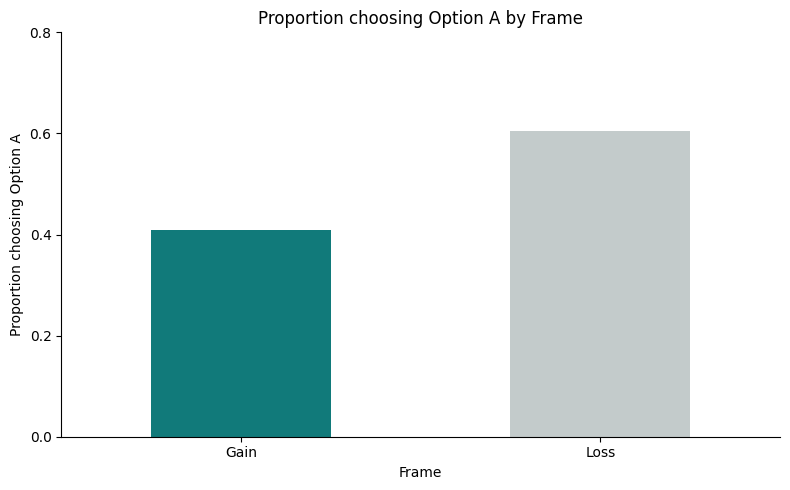

<Figure size 640x480 with 0 Axes>

In [18]:
##Graph Proportion Choosing Option A by Frame 


agg_data = df_gpt3.groupby('frame').option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']
plt.figure(figsize=(8, 5))
palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}
bars = sns.barplot(data=agg_data, x='frame', y='prop_A_mean', palette=palette, dodge=False,width=.5 ) 
bars.set_yticks([0,.2,.4,.6,.8,])
bars.set_xticklabels(labels = ["Gain", "Loss"], rotation = 0)


sns.despine()
plt.ylabel('Proportion choosing Option A')
plt.xlabel('Frame')

plt.title('Proportion choosing Option A by Frame')
plt.tight_layout()
plt.show()
plt.savefig('PropA_scenario_exp2.png')

ValueError: min() arg is an empty sequence

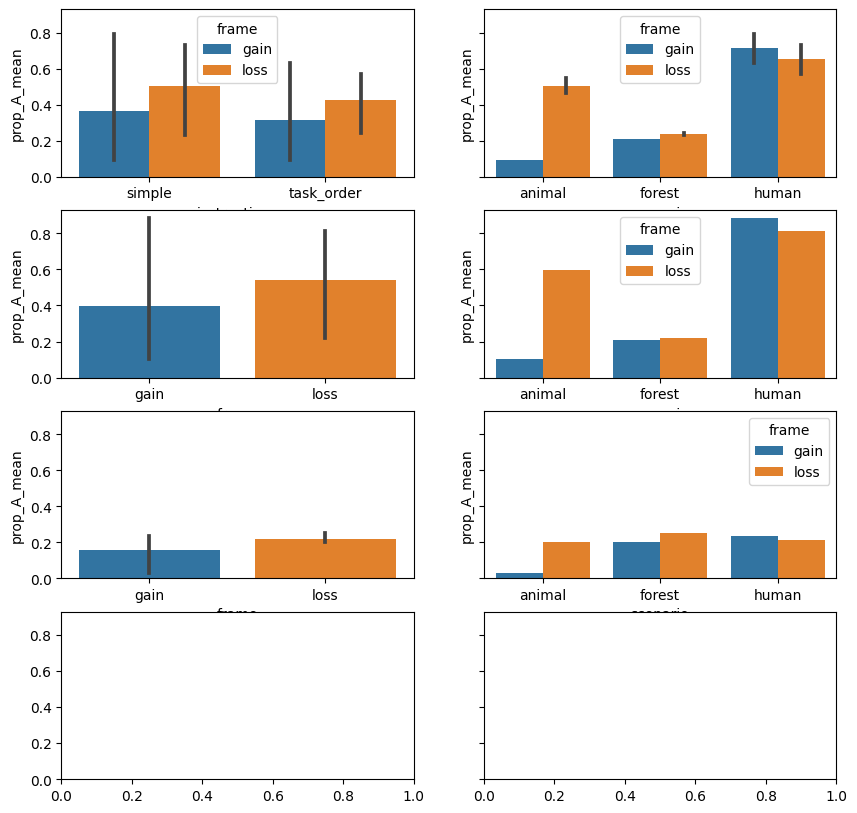

In [19]:
###Plotting by Inustrctions 

df_concat = pd.concat([df_combo2,df_combo5,df_combo6], axis = 0)
agg_data2 = df_combo2.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A")
).reset_index()
agg_data5 = df_combo5.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A")
).reset_index()
agg_data6 = df_combo6.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A")
).reset_index()

pivot_2 = pd.pivot(data = agg_data2, index = 'scenario', columns = 'frame', values = 'prop_A_mean').reset_index()
pivot_2.round(4)
pivot_5 = pd.pivot(data = agg_data2, index = 'scenario', columns = 'frame', values = 'prop_A_mean').reset_index()
pivot_5.round(4)
pivot_6 = pd.pivot(data = agg_data2, index = 'scenario', columns = 'frame', values = 'prop_A_mean').reset_index()
pivot_6.round(4)

##df_combo2
#df_combo5
#df_combo6

agg_concat = df_concat.groupby(['scenario', 'instructions', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A")
).reset_index()

fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)  # Changed figsize to make the figure taller
#plt.subplots_adjust( wspace=.25, hspace=.5)

#sns.histplot(data=main_analysis, x='rating_num', ax=axes[0][0], color= blue, edgecolor="w")


ins = sns.barplot(data=agg_concat, x='instructions', y='prop_A_mean', hue='frame', ax=axes[0][0] ) ##, capsize=0.05) ##, width = 0.4)
scn = sns.barplot(data=agg_concat, x='scenario', y='prop_A_mean', hue='frame', ax=axes[0][1], ) ##, capsize=0.05) ##, width = 0.4)

simple = sns.barplot(data=agg_data2, x='frame', y='prop_A_mean', ax=axes[1][0] ) ##, capsize=0.05) ##, width = 0.4)
scn_simp = sns.barplot(data=agg_data2, x='scenario', y='prop_A_mean', hue='frame', ax=axes[1][1], ) ##, capsize=0.05) ##, width = 0.4)

task_ord = sns.barplot(data=agg_data5, x='frame', y='prop_A_mean', ax=axes[2][0] ) ##, capsize=0.05) ##, width = 0.4)
scn_ord = sns.barplot(data=agg_data5, x='scenario', y='prop_A_mean', hue='frame', ax=axes[2][1], ) ##, capsize=0.05) ##, width = 0.4)

chain = sns.barplot(data=agg_data6, x='frame', y='prop_A_mean', ax=axes[3][0] ) ##, capsize=0.05) ##, width = 0.4)
scn_chain= sns.barplot(data=agg_data6, x='scenario', y='prop_A_mean', hue='frame', ax=axes[3][1], ) ##, capsize=0.05) ##, width = 0.4)


##bars.set_xticklabels(labels = clean_test_names, rotation = 0)


In [ ]:
#35 * 5 = 175
#28 * 5 = 140

#37 * 5 = 185
#34 * 5 = 170

#37 * 5 = 185
#30 * 5 = 120


#loss total = 510
#gain total = 495

In [47]:
###Table for Temp .7
t_7 = df_gpt3[df_gpt3['temperature'] == 1]
###tests = ["['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']", "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']","['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']" ]
#t_7 = t_7[t_7['test'].isin(tests)]
#t_7 = t_7[t_7['run_type'] == 'round 1']
tst0 =  t_7.groupby(['test','scenario' ,'frame'])['option_selected'].agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()

pd.crosstab([t_7['test'] ,  t_7['frame']] ,[t_7['scenario']], margins=True).reset_index()

#pd.crosstab(t_7['test'],[t_7['scenario'], t_7['frame']])
pd.pivot(tst0, index = ['test', 'scenario'], columns = 'frame', values = 'prop_A_mean').round(2).reset_index()

frame,test,scenario,gain,loss
0,"['combo 1A', 'system_message_baseline1', 'user...",animal,0.21,0.66
1,"['combo 1A', 'system_message_baseline1', 'user...",forest,0.37,0.37
2,"['combo 1A', 'system_message_baseline1', 'user...",human,0.67,0.51
3,"['combo 2', 'system_message_hum', 'user_messag...",animal,0.65,0.41
4,"['combo 2', 'system_message_hum', 'user_messag...",forest,0.34,0.36
5,"['combo 2', 'system_message_hum', 'user_messag...",human,0.87,0.73
6,"['combo 3', 'system_message_risk', 'user_messa...",animal,0.53,0.89
7,"['combo 3', 'system_message_risk', 'user_messa...",forest,0.40,0.25
8,"['combo 3', 'system_message_risk', 'user_messa...",human,0.53,0.78
9,"['combo 3B', 'system_message_risk', 'user_mess...",animal,0.68,NaN


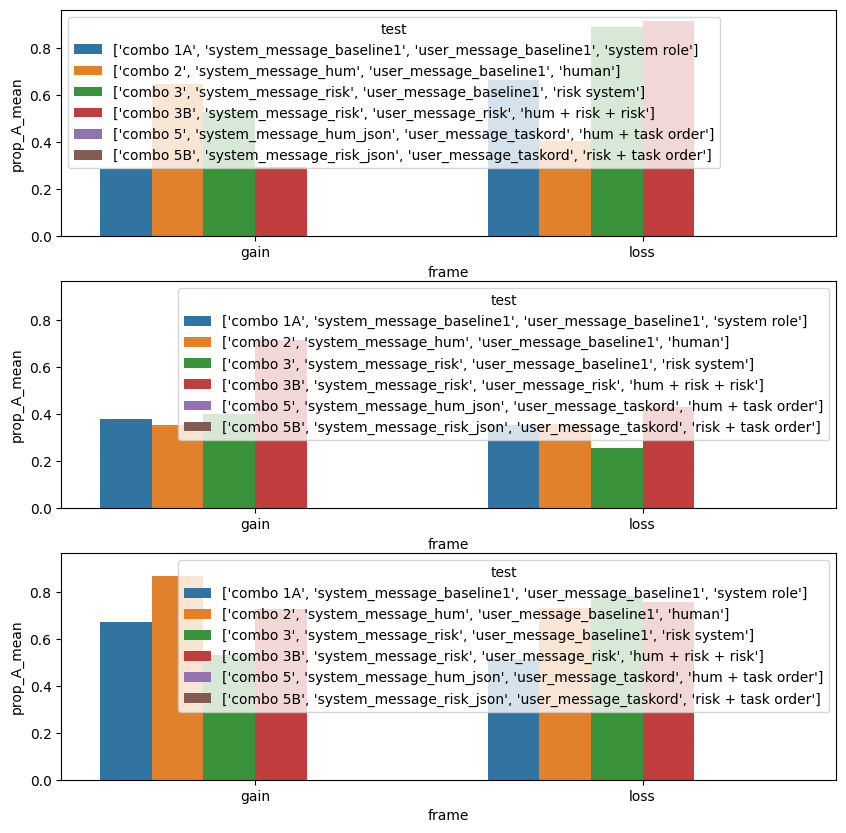

In [52]:
##graph by scenario compare
df_animal_t0 = df_animal[df_animal['temperature'] == 1]
df_for_t0 = df_forest[df_forest['temperature'] == 1]
df_hum_t0 = df_human[df_human['temperature'] == 1]

agg_data_an = df_animal_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()
agg_data_for = df_for_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()

agg_data_hum = df_hum_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()


fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=True)  # Changed figsize to make the figure taller
bar1 = sns.barplot(data = agg_data_an, x = 'frame', y = 'prop_A_mean', ax =axes[0], hue = 'test'  )
bar2 = sns.barplot(data = agg_data_for, x = 'frame', y = 'prop_A_mean', ax =axes[1], hue = 'test'  )
bar3 = sns.barplot(data = agg_data_hum, x = 'frame', y = 'prop_A_mean', ax =axes[2], hue = 'test'  )

#fig.legend( loc='upper center', bbox_to_anchor=(0.5, .35), ncol=2)
plt.show()

In [24]:
##Graph Proportion Choosing Option A by Test (Temp 0 and .7)

t0 = df_gpt3[df_gpt3['temperature'] == 0]

t0 = t0[t0['scenario'] == 'human']

tests = list(t0.test.unique())
combo_names = [item.split(",")[0].strip("[]' ") for item in tests]

t_7 = df_gpt3[df_gpt3['temperature'] == .7]
t_7 = t_7[t_7['scenario'] == 'human']

order = ["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
 "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
 "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",
 "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
 "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"]

t_7['test'] = pd.Categorical(t_7['test'], categories=order, ordered=True)
t_7 = t_7.sort_values('test')
tests7 = list(t_7.test.unique())
combo_names7 = [item.split(",")[0].strip("[]' ") for item in tests7]

agg_data0 = t0.groupby(['test', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data0['conf_int'] = 1.96 * agg_data0['prop_A_std']

agg_data0 = agg_data0[agg_data0['test'].isin(tests7)]

agg_data7 = t_7.groupby(['test', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data7['conf_int'] = 1.96 * agg_data7['prop_A_std']


fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharey=True)  # Changed figsize to make the figure taller
palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data0, x='test', y='prop_A_mean', hue='frame', ax=axes[0],palette=palette, width = .7 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_title("Temp 0")

bars2 = sns.barplot(data=agg_data7, x='test', y='prop_A_mean', hue='frame', ax=axes[1],palette=palette, width = .7 ) ##, capsize=0.05) ##, width = 0.4)
bars2.set_title("Temp 7")

bars.set_xticklabels(labels = combo_names7, rotation = 0)
bars2.set_xticklabels(labels = combo_names7, rotation = 0)

#for i, bar in enumerate(bars.patches):
  #  yval = bar.get_height()
   # yerr = agg_data['conf_int'].iloc[i]
    #bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
     #            yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)
def change_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
##plt.xlabel('Scenario', labelpad = 5)
#plt.title('Proportion choosing Option A by Scenario and Frame')
##plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

plt.show()

AttributeError: 'float' object has no attribute 'split'

In [25]:
##Graph Proportion Choosing Option A by Test (Temp .7) -- Frame Scenario
t1 = df_gpt3[df_gpt3['temperature'] == .7]
#order = ["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
#"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
# "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
# "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",
# "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
# "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"]

#t1['test'] = pd.Categorical(t1['test'], categories=order, ordered=True)
t1 = t1.sort_values('test')

tests = list(t1.test.unique())
combo_names = [item.split(",")[0].strip("[]' ") for item in tests]
agg_data = t1.groupby(['combo', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']
agg_data['frame_scn'] = agg_data['frame'] + " - " + agg_data['scenario']
order_test_scenario = agg_data['frame_scn'].unique()

order = ['gain - animal', 'loss - animal','gain - forest', 'loss - forest', 'gain - human', 'loss - human']
agg_data['frame_scn'] = pd.Categorical(agg_data['frame_scn'], categories=order, ordered=True)


plt.figure(figsize=(30, 5))
#palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='frame_scn', y='prop_A_mean', hue='combo',  width = .7 ) ##, capsize=0.05) ##, width = 0.4)
#bars.set_xticklabels(labels = combo_names, rotation = 0)
bars.set_yticks([0,.2,.4,.6,.8,])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
##plt.xlabel('Scenario', labelpad = 5)
plt.title('Proportion choosing Option A by Scenario and Frame')
##plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig('PropA_test_exp2.png')

AttributeError: 'float' object has no attribute 'split'

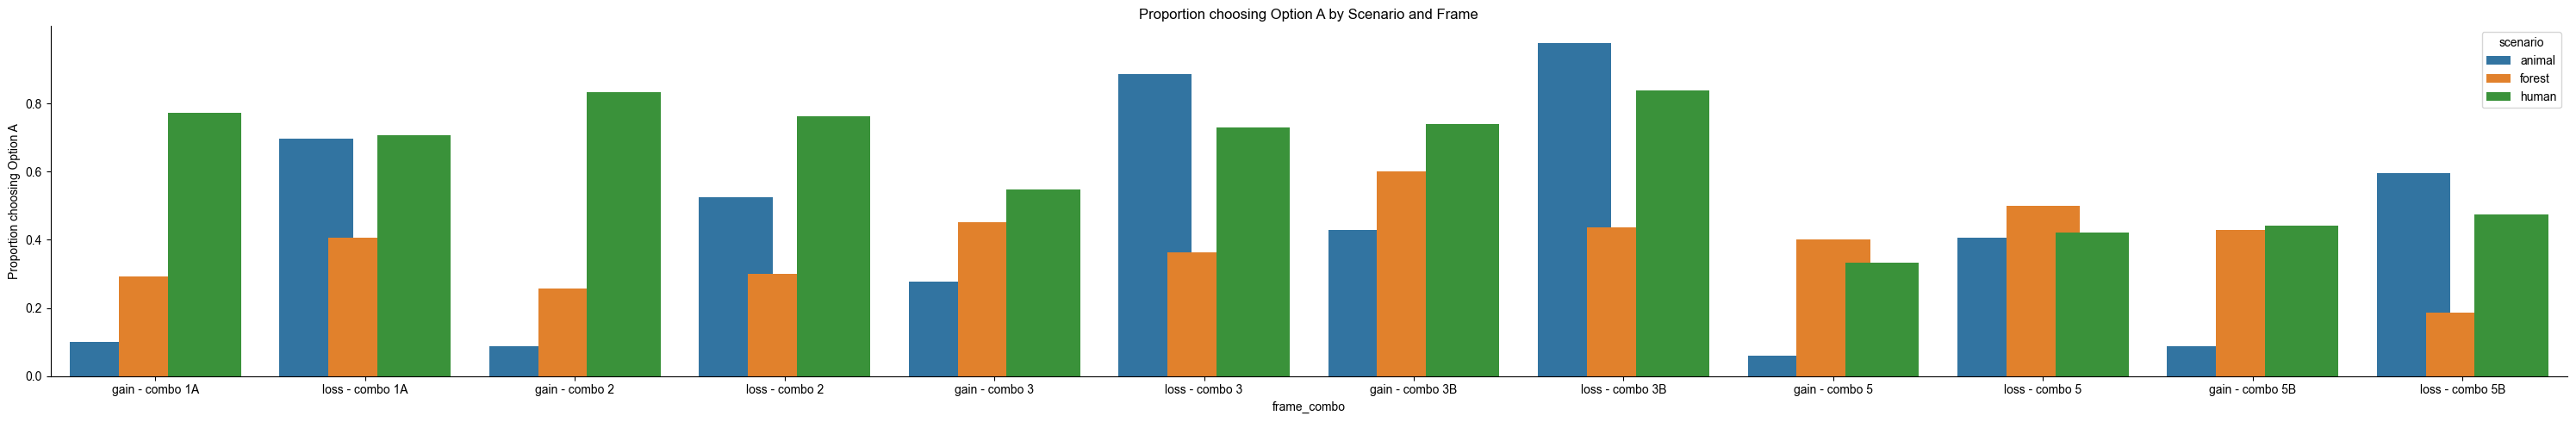

<Figure size 640x480 with 0 Axes>

In [1449]:
##Graph Proportion Choosing Option A by Test (Temp .7) -- Frame Combo (grouping by Combo)
df_gpt3['combo'] = df_gpt3['test'].apply(lambda x: x.split(",")[0].strip("[]' ") )
t1 = df_gpt3[df_gpt3['temperature'] == .7]
#order = ["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
#"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
# "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
# "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",
# "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
# "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']"]

#t1['test'] = pd.Categorical(t1['test'], categories=order, ordered=True)
t1 = t1.sort_values('test')

tests = list(t1.test.unique())
combo_names = [item.split(",")[0].strip("[]' ") for item in tests]
agg_data = t1.groupby(['combo', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']
agg_data['frame_combo'] = agg_data['frame'] + " - " + agg_data['combo']
order_test_scenario = agg_data['frame_combo'].unique()
plt.figure(figsize=(30, 5))
#palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='frame_combo', y='prop_A_mean', hue='scenario',  width = .7 ) ##, capsize=0.05) ##, width = 0.4)
#bars.set_xticklabels(labels = combo_names, rotation = 0)
bars.set_yticks([0,.2,.4,.6,.8,])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
##plt.xlabel('Scenario', labelpad = 5)
plt.title('Proportion choosing Option A by Scenario and Frame')
##plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig('PropA_test_exp2.png')

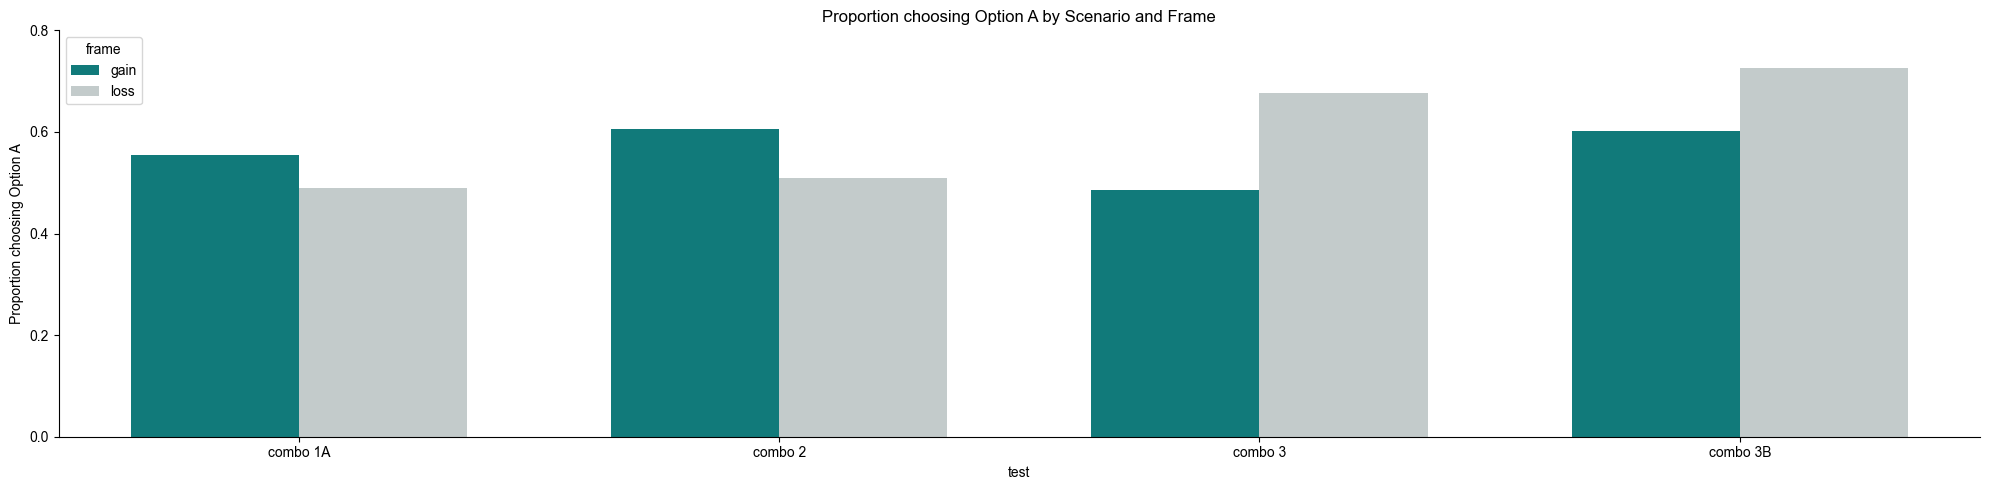

<Figure size 640x480 with 0 Axes>

In [1046]:
##Graph Proportion Choosing Option A by Test (Temp 1)

t1 = df_gpt3[df_gpt3['temperature'] == 1]
t1.test = t1.test.replace("['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk', 'take2']", "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']")
tests = list(t1.test.unique())
combo_names = [item.split(",")[0].strip("[]' ") for item in tests]
combo_names
agg_data = t1.groupby(['test', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(20, 5))
palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='test', y='prop_A_mean', hue='frame', palette=palette, width = .7 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = combo_names, rotation = 0)
bars.set_yticks([0,.2,.4,.6,.8,])

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
##plt.xlabel('Scenario', labelpad = 5)
plt.title('Proportion choosing Option A by Scenario and Frame')
##plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig('PropA_test_exp2.png')

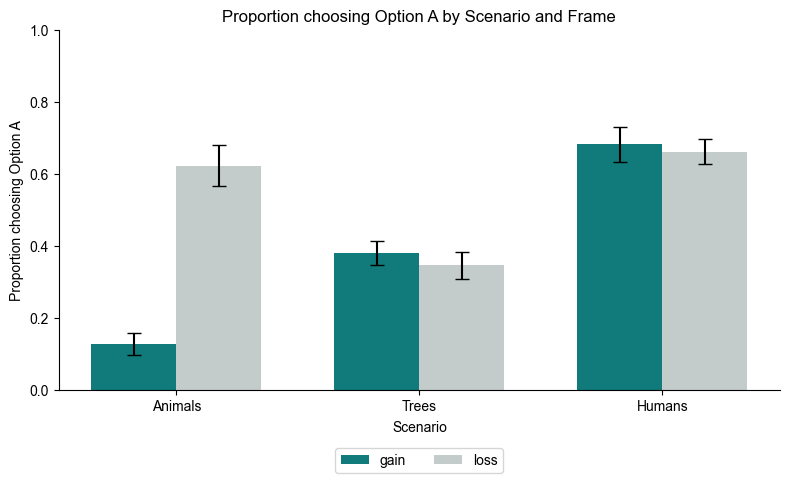

In [732]:
##GraphProportion Choosing Option A by Scenario 

plt.rcParams["font.family"] = "arial"
agg_data = t7.groupby(['scenario', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(8, 5))
palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='scenario', y='prop_A_mean', hue='frame', palette=palette, width = .7 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = ['Animals', 'Trees', 'Humans' ], rotation = 0)

for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Scenario', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8, 1])
plt.yticks(fontsize=10)
plt.title('Proportion choosing Option A by Scenario and Frame')
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()


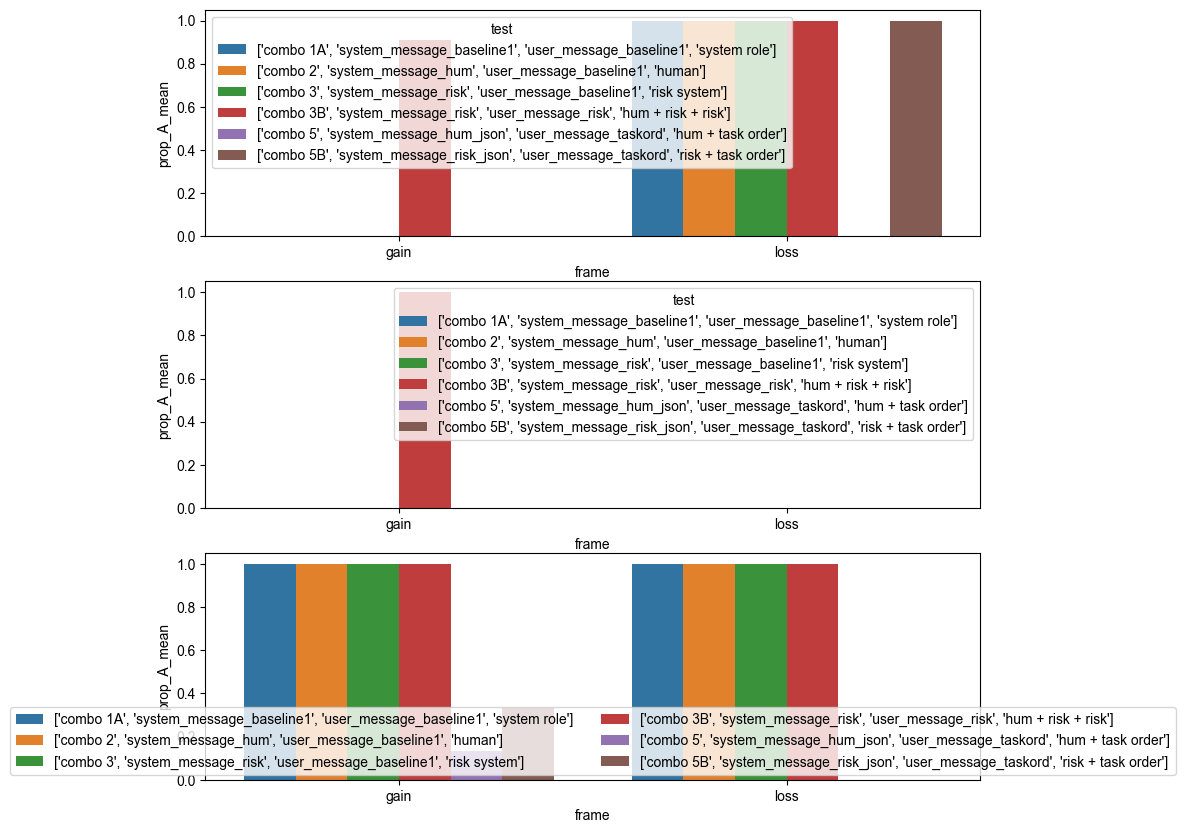

In [ ]:
##graph by scenario compare
df_animal_t0 = df_animal[df_animal['temperature'] == 0]
df_for_t0 = df_forest[df_forest['temperature'] == 0]
df_hum_t0 = df_human[df_human['temperature'] == 0]


agg_data_an = df_animal_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()
agg_data_for = df_for_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()

agg_data_hum = df_hum_t0.groupby([ 'test', 'frame', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
).reset_index()


agg_data1.prop_A_mean = agg_data1.prop_A_mean.round(4)
piv = pd.pivot(data = agg_data1, index = ['test', 'scenario'] ,columns = 'frame', values = 'prop_A_mean').reset_index()

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharey=True)  # Changed figsize to make the figure taller
sns.barplot(data = agg_data_an, x = 'frame', y = 'prop_A_mean', ax =axes[0], hue = 'test'  )
sns.barplot(data = agg_data_for, x = 'frame', y = 'prop_A_mean', ax =axes[1], hue = 'test'  )
sns.barplot(data = agg_data_hum, x = 'frame', y = 'prop_A_mean', ax =axes[2], hue = 'test'  )

plt.legend( loc='upper center', bbox_to_anchor=(0.5, .35), ncol=2)
plt.show()

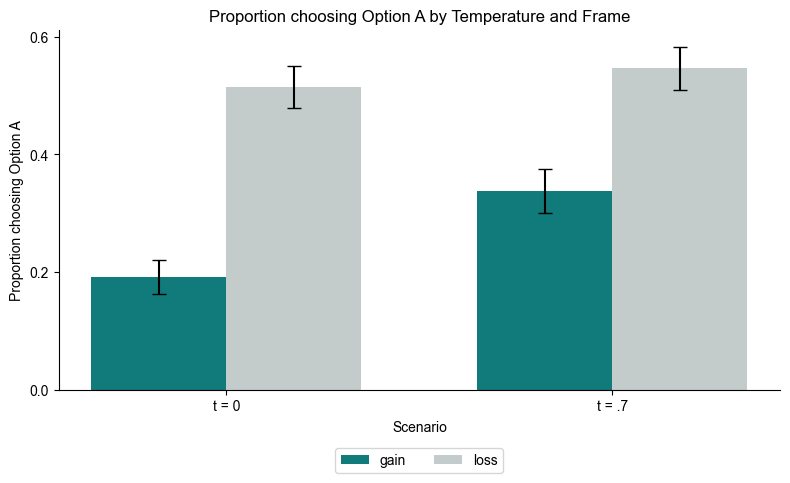

<Figure size 640x480 with 0 Axes>

In [77]:
##Graph Proportion Choosing Option A by Temperature 

plt.rcParams["font.family"] = "arial"
agg_data = df_gpt3.groupby(['temperature', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(8, 5))
palette = {'gain': '#008B8B', 'loss': '#C1CDCD'}

bars = sns.barplot(data=agg_data, x='temperature', y='prop_A_mean', hue='frame', palette=palette, width = .7 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = ['t = 0', 't = .7' ], rotation = 0)
bars.set_yticks([0,.2,.4,.6,.8,])
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A')
plt.xlabel('Scenario', labelpad = 5)
plt.title('Proportion choosing Option A by Temperature and Frame')
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()
plt.savefig('PropA_temp_exp2.png')

In [78]:
##Rating Crosstab
rating_cross_t0 = pd.crosstab(df_gpt3['test'] ,[df_gpt3['temperature'],df_gpt3['frame']], values = df_gpt3['rating_num'], aggfunc= 'mean')
rating_cross_t0.round(2)

temperature                                                                             0.0  \
frame                                                                                  gain   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      4.79   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.79   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            4.79   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     6.49   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  5.53   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 6.08   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              4.14   

temperature                                                                                  \
frame                                                                                  loss   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      3.10   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   3.10   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            3.10   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     7.00   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  5.05   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 4.70   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              3.19   

temperature                                                                             0.7  \
frame                                                                                  gain   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      4.69   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.73   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            4.46   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     5.12   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  4.68   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 4.81   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              4.45   

temperature                                                                                  
frame                                                                                  loss  
test                                                                                         
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      3.72  
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.16  
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            3.83  
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     4.64  
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  4.39  
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 4.37  
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              3.36

In [281]:
###Complex Chart for Scenario, Insturctions, and Frame

# Sample data
grouped = df.groupby(['instructions', 'scenario', 'frame']).option_selected.agg(value = lambda x: np.mean(x == "Proposal A")).unstack().reset_index()

for idx, (instruction, group) in enumerate(grouped.groupby('instructions')):
    for j, scenario in enumerate(group['scenario'].unique()):
        gain_label = f"Gain - {scenario}"
        loss_label = f"Loss - {scenario}"
# Colors
colors = np.array([
    [0.267004, 0.004874, 0.329415, 1.],
    [0.127568, 0.566949, 0.550556, 1.],
    [0.993248, 0.906157, 0.143936, 1.]
])
alpha = 0.5  # Transparency for 'loss' bars

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
offsets = [-bar_width, 0, bar_width]

for idx, (instruction, group) in enumerate(grouped.groupby('instructions')):
    for j, scenario in enumerate(group['scenario'].unique()):
        # Determine color for this scenario
        color = colors[j]
        
        # Plot Gain bars
        ax.bar(
            idx + offsets[j],
            group[group['scenario'] == scenario][('value', 'gain')].values,
            color=color,
            width=bar_width,
            label=f"Gain - {scenario}" if f"Gain - {scenario}" not in [rect.get_label() for rect in ax.patches]
            else ""
        )
        
        # Plot Loss bars
        ax.bar(
            idx + offsets[j],
            group[group['scenario'] == scenario][('value', 'loss')].values,
            bottom=group[group['scenario'] == scenario][('value', 'gain')].values,
            color=color,
            alpha=alpha,
            width=bar_width,
            label=f"Loss - {scenario}" if f"Loss - {scenario}" not in [rect.get_label() for rect in ax.patches]
            else ""
        )

ax.set_xticks(np.arange(len(grouped['instructions'].unique())))
ax.set_xticklabels(grouped['instructions'].unique())
#ax.legend()

plt.show()


NameError: name 'df' is not defined

#### Descriptive Stats

In [71]:
print(df_gpt3['option_selected'].value_counts(normalize=True))
print('\n\n')
print(df_gpt3.groupby('frame')['option_selected'].value_counts(normalize=True))

option_selected
Proposal B    0.600569
Proposal A    0.399431
Name: proportion, dtype: float64



frame  option_selected
gain   Proposal B         0.735209
       Proposal A         0.264791
loss   Proposal A         0.530112
       Proposal B         0.469888
Name: proportion, dtype: float64


<Axes: xlabel='rating_num', ylabel='Count'>

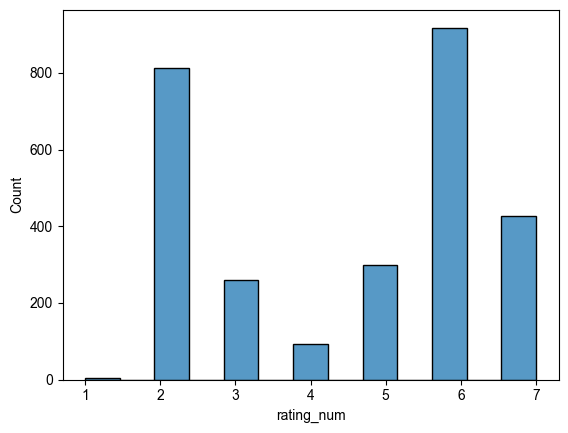

In [89]:
##Graphing
sns.histplot(df_gpt3['rating_num'])


In [ ]:

sns.histplot(df_gpt3['rating_num'])

<Axes: ylabel='Count'>

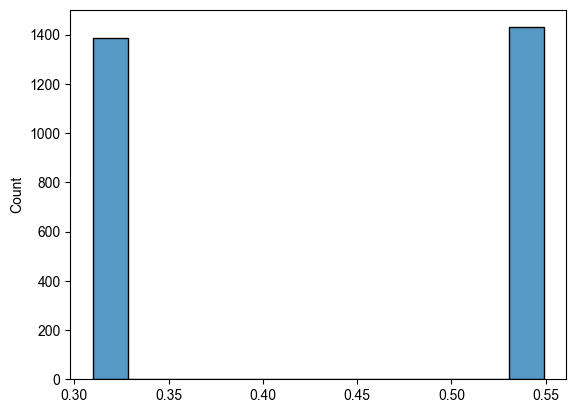

In [497]:
##histogram of probabilites 
import seaborn as sns
proba = 1 / (1 + np.exp( - logit_reg_rev.fittedvalues ))
sns.histplot(proba)

In [ ]:
t0 = df_gpt3[df_gpt3['temperature'] == 0 ]

pd.crosstab(df_gpt3['test'], [df_gpt3['temperature'], df_gpt3['frame']], margins = True).reset_index()

### Hypothesis Testing

- H4: GPT-3.5 Turbo will also exhibit a framing effect, mirroring the tendencies observed in human decision-making.
    - H4.1 GPT-3.5 will show a higher propotion of Option A in gain frame and a higher proportion of Option B in loss frame
- H4.2: A higher temperature will increase the framing effect observed in GPT-3.5 Turbo's choices.
- H4.3: The model prompt conditions (risk, system role, and instructions) will influence the framing effect observed in GPT-3.5 Turbo's choices.
- H4.4: The scenario will influence the strength of the framing effect in GPT-3.5 Turbo's choices.

#### Stat Tests for Hypotheses

H1 & H2: Framing Effect and Preference Ratings

In [130]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(df_gpt3['frame'], df_gpt3['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

###H2: Kruskal-Wallis Test for Rating ##CHECK
stat, p_val2 = stats.mannwhitneyu(df_gpt3[df_gpt3['frame']=='gain']['rating_num'], df_gpt3[df_gpt3['frame']=='loss']['rating_num'])


###Output as a table
results = {
    ('option selected'): {
        'chi2/stat': chi2,
        'p_val': pval,
        'sig effect': pval < .05
    },
    ('rating number'): {
        'chi2/stat': stat,
        'p_val': p_val2,
        'sig effect': p_val2 < .05
    }}

df_op = pd.DataFrame.from_dict(results)
df_op



,option selected,rating number
chi2/stat,163.277173,1163582.0
p_val,0.0,0.0
sig effect,True,True


H3 - H5: Influence of Prompt 

In [64]:
############## ---- Instructions ---- ###############
#Instructions (Op Selected)
ins_cont_table = pd.crosstab(df_gpt3['instructions'], df_gpt3['option_selected'])
chi2_i, pval_i, _, _ = stats.chi2_contingency(ins_cont_table)
#Instructions (Rating)
stat_i, pval_i2 = stats.kruskal(df_gpt3[df_gpt3['instructions']=='simple']['rating_num'], df_gpt3[df_gpt3['instructions']=='chain']['rating_num'], df_gpt3[df_gpt3['instructions']=='task_order']['rating_num'])

############## ---- System Role ---- ###############

#Sys Role (Op Selected)
sys_cont_table = pd.crosstab(df_gpt3['sys_role'], df_gpt3['option_selected'])
chi2_s, pval_s, _, _ = stats.chi2_contingency(ins_cont_table)
#Sys Rol (Rating)
stat_s, pval_s2= stats.kruskal(df_gpt3[df_gpt3['sys_role']=='neutral_system']['rating_num'], df_gpt3[df_gpt3['sys_role']=='human']['rating_num'])

############## ---- Risk ---- ###############

#Risk (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['risk'], df_gpt3['option_selected'])
chi2_r, pval_r, _, _ = stats.chi2_contingency(ins_cont_table)
#Risk (Rating)
stat_r, pval_r2= stats.kruskal(df_gpt3[df_gpt3['risk']=='neutral_risk']['rating_num'], df_gpt3[df_gpt3['risk']=='risk']['rating_num'])

############## ---- Temp ---- ###############
#Temp (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['temperature'], df_gpt3['option_selected'])
chi2_t, pval_t, _, _ = stats.chi2_contingency(ins_cont_table)
#Temp (Rating)
stat_t, pval_t2= stats.kruskal(df_gpt3[df_gpt3['temperature']==0]['rating_num'], df_gpt3[df_gpt3['temperature']==.7]['rating_num'])

In [70]:
###Output as a table
dict_instructions = {
    ('instructions', 'option selected'): {
        'chi2/stat': round(chi2_i,3),
        'p_val': pval_i,
        'sig effect': pval_i < .05
    },
    ('instructions', 'rating number'): {
        'chi2/stat': round(stat_i,3),
        'p_val': pval_i2,
        'sig effect': pval_i2 < .05
    }
}
dict_sys_role = {
    ('sys role', 'option selected'): {
        'chi2/stat': round(chi2_s,3),
        'p_val': pval_s,
        'sig effect': pval_s < .05
    },
    ('sys role', 'rating number'): {
        'chi2/stat': round(stat_s,3),
        'p_val': pval_s2,
        'sig effect': pval_s2 < .05
    }
}
dict_risk = {
    ('risk', 'option selected'): {
        'chi2/stat': round(chi2_r,3),
        'p_val': pval_r,
        'sig effect': pval_r < .05
    },
    ('risk', 'rating number'): {
        'chi2/stat': round(stat_r,3),
        'p_val': pval_r2,
        'sig effect': pval_r2 < .05
    }
}
dict_temp = {
    ('temp', 'option selected'): {
        'chi2/stat': round(chi2_t,3),
        'p_val': pval_t,
        'sig effect': pval_t < .05
    },
    ('temp', 'rating number'): {
        'chi2/stat': round(stat_t,3),
        'p_val': round(pval_t2,3),
        'sig effect': pval_t2 < .05,
    }
}
df_instructions = pd.DataFrame(dict_instructions)
df_sys_role = pd.DataFrame(dict_sys_role)
df_risk = pd.DataFrame(dict_risk)
df_temp = pd.DataFrame(dict_temp)
test_results_df = pd.concat([df_instructions, df_sys_role, df_risk, df_temp], axis=1)
test_results_df.to_csv('test_prompt_results.csv')
test_results_df.round(2)

instructions                      sys role                \
           option selected rating number option selected rating number   
chi2/stat           122.21       256.261          122.21        28.497   
p_val                  0.0           0.0             0.0           0.0   
sig effect            True          True            True          True   

                      risk                          temp                
           option selected rating number option selected rating number  
chi2/stat           122.21        70.757          122.21        15.767  
p_val                  0.0           0.0             0.0           0.0  
sig effect            True          True            True          True

#### Regression Tests for Hypotheses 

In [372]:
##prep variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


##data cleaning & dummy coding 
df_gpt3_w_dummy = pd.get_dummies(df_gpt3, columns=['test'], prefix='participant_type', drop_first=True)
    #participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']	
    #participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']	   
    #participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']	
    #participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']		
    #participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']	
    #participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']
    
##cat code temperature variable 

##rename variables for 
df_gpt3_w_dummy= df_gpt3_w_dummy.rename(columns = {
    "participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":'human', 
    "participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']": 'hum_risk',
    "participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": 'hum_taskord',
    "participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": 'hum_risk_taskord',
    "participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']": 'hum_chain',
    "participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": 'hum_risk_chain'
    })
##dummy_cols = ['human', 'hum_risk', 'hum_taskord', 'hum_risk_taskord', 'hum_chain', 'hum_risk_chain']
##df_gpt3_w_dummy[dummy_cols] = df_gpt3_w_dummy[dummy_cols].astype(int)

df_gpt3['temp_var'] = df_gpt3.temperature.astype('category').cat.codes ##temp 0 = 0; temp .7 = 1


In [373]:
##sep conditions for gain and loss 
gain_cond = df_gpt3[df_gpt3['frame'] == 'gain']
loss_cond = df_gpt3[df_gpt3['frame'] == 'loss']
##crete df for each test 
tests = {f'df_{test}': df_gpt3[df_gpt3['test'] == test] for test in df_gpt3['test'].unique()}
for key in tests.keys():
    print(key)

df_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']
df_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']
df_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']
df_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']
df_['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']
df_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']
df_['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']


##### Logit Regression (Hyp 1)

H4.1 GPT-3.5 will show a higher propotion of Option A in gain frame and a higher proportion of Option B in loss frame 
- H4.1.1 All AI models will exhibit the risky choice framing effect, demonstrating preference for certain option in the gain condition 

In [378]:
#Simple
logit_reg = smf.logit('option_selected_A ~ frame_gain', df_gpt3).fit()
print(logit_reg.summary())
# the likelihood (in log-odds) of choosing option A decreases compared to the loss frame.

####With controls 

##Scenario  
logit_reg_scn = smf.logit('option_selected_A ~ frame_gain + C(scenario)', df_gpt3).fit()
print(logit_reg_scn.summary())

##Scenario + Temp + Model Variables 
logit_reg_scn_temp_test_var = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature) + C(instructions) + C(risk) + C(sys_role)', df_gpt3).fit()
print(logit_reg_scn_temp_test_var.summary())


######### ---- Create Tables ---- ######### 

#Create tables for Simple 
from tabulate import tabulate

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Frame (Gain)': f"{round(model.params['frame_gain'],3)} ({round(model.bse['frame_gain'],3)})",
        'Constant': f"{round(model.params['Intercept'],3)} ({round(model.bse['Intercept'],3)})",
        'P-value': f"{round(p_val,3)}{asterisks}",
        'Confidence Interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),4),
        'Observations ':model.nobs,
        'Pseudo R^2': round(model.prsquared,3)

    }

###table for Simple Comparison 
summary_stats_logit_v1 = [get_summary_stats(logit_reg),
                          get_summary_stats(logit_reg_scn), 
                          get_summary_stats(logit_reg_scn_temp_test_var)]

                        
summary_logit_df1 = pd.DataFrame(summary_stats_logit_v1)
summary_logit_df1.T

table1 = summary_logit_df1.T
basic_models = summary_logit_df1.T
print(basic_models)
basic_models.to_csv('basic_models_AI.csv', index=False)


Optimization terminated successfully.
         Current function value: 0.635516
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2812
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 Aug 2023   Pseudo R-squ.:                 0.05539
Time:                        15:27:42   Log-Likelihood:                -1788.3
converged:                       True   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 1.579e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1206      0.053      2.274      0.023       0.017       0.225
frame_gain    -1.1418      0.

In [346]:
##Simple Models for Gain or Loss 

##Log Odds of Option A (certain) Only in Gain Condition 
logit_reg_gain = smf.logit('option_selected_A ~ 1', gain_cond).fit()
print("frame coeff:", logit_reg_gain.params['Intercept'])
print("frame p-vale:", logit_reg_gain.pvalues['Intercept'])
print(logit_reg_gain.summary())
##opposite framing effect 

##Log Odds of Option B (risky) Only in Loss Condition 
logit_reg_loss = smf.logit('option_selected_B ~ 1', loss_cond).fit()
print("frame coeff:", logit_reg_loss.params['Intercept'])
print("frame p-vale:", logit_reg_loss.pvalues['Intercept'])
print(logit_reg_loss.summary())

##With Controls  



Optimization terminated successfully.
         Current function value: 0.578008
         Iterations 5
frame coeff: -1.0212151851681508
frame p-vale: 3.734961532562189e-63
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 1386
Model:                          Logit   Df Residuals:                     1385
Method:                           MLE   Df Model:                            0
Date:                Mon, 21 Aug 2023   Pseudo R-squ.:               1.291e-10
Time:                        14:52:41   Log-Likelihood:                -801.12
converged:                       True   LL-Null:                       -801.12
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0212      0.061    -16

H4.2: A higher temperature will increase the framing effect observed in GPT-3.5 Turbo's choices.

In [344]:
## Temp Basic 
logit_reg_temp = smf.logit('option_selected_A ~ frame_gain * C(temperature)', df_gpt3).fit()
print(logit_reg_temp.summary())
#framing effect is neg, & significant 

logit_reg_tempall = smf.logit('option_selected_A ~ frame_gain * C(temperature) + C(scenario)', df_gpt3).fit()
print(logit_reg_tempall.summary())

Optimization terminated successfully.
         Current function value: 0.628062
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2820
Model:                          Logit   Df Residuals:                     2816
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Aug 2023   Pseudo R-squ.:                 0.06659
Time:                        14:50:04   Log-Likelihood:                -1771.1
converged:                       True   LL-Null:                       -1897.5
Covariance Type:            nonrobust   LLR p-value:                 1.703e-54
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0642      0.075      0.85

H4.3: The model prompt conditions (risk, system role, and instructions) will impact the framing effect observed in GPT-3.5 Turbo's choices.

In [377]:
##Models for Instructions, Risk, and Sys Role 
    ###check 'moderate' 
    #standalone model 

logit_reg_ins = smf.logit('option_selected_A ~ frame_gain * C(instructions)', df_gpt3).fit()
print(logit_reg_ins.summary())

logit_reg_sys = smf.logit('option_selected_A ~ frame_gain * C(sys_role)', df_gpt3).fit()
print(logit_reg_sys.summary())

logit_reg_risk = smf.logit('option_selected_A ~ frame_gain * C(risk)', df_gpt3).fit()
print(logit_reg_risk.summary())

##add in interaction term for all prompt variables
logit_var_combined = smf.logit('option_selected_A ~ frame_gain * C(instructions) + frame_gain * C(risk) + frame_gain * C(sys_role)', df_gpt3).fit()
print(logit_var_combined.summary())


##add in interaction term for all prompt variables
logit_var_combined_all = smf.logit('option_selected_A ~ frame_gain * C(instructions) + frame_gain * C(risk) + frame_gain * C(sys_role) + C(scenario) + C(temperature)', df_gpt3).fit()
print(logit_var_combined_all.summary())

Optimization terminated successfully.
         Current function value: 0.609484
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2808
Method:                           MLE   Df Model:                            5
Date:                Mon, 21 Aug 2023   Pseudo R-squ.:                 0.09408
Time:                        15:23:53   Log-Likelihood:                -1715.1
converged:                       True   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 7.956e-75
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.6

In [348]:
##Tables to compare Results
def extract_from_model(model):
    """Extract coefficients, p-values from model object."""
    params = model.params
    pvals = model.pvalues
    std_err = model.bse
    return params, pvals, std_err 

def asterick(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.10:
        return '*'
    return ''


def create_compare_table(*models):
    """Create a table using coefficients, standard errors, and p-values."""
    # Define the desired ordering of the terms
    ordered_vars = ['frame_gain', 'C(instructions)[T.chain]', 'C(instructions)[T.task_order]', 
                    'C(sys_role)[T.neutral_system]', 'C(sys_role)[T.human]', 'C(risk)[T.risk]', 'Intercept']
    all_vars = set().union(*[set(model.params.index) for model in models])
    for var in all_vars:
        if var not in ordered_vars:
            ordered_vars.append(var)
    data = {'Variable': ordered_vars}
    for i, model in enumerate(models, start=1):
        params, pvals, std_err = extract_from_model(model)
        model_data = []
        for term in ordered_vars:
            if term in params:
                model_data.append(f"{params[term]:.3f} ({pvals[term]:.3f}{asterick(pvals[term])})")
            else:
                model_data.append("--")
        data[f'Model {i}'] = model_data

    df = pd.DataFrame(data).set_index('Variable')
    return df

# Assuming logit_reg, logit_reg_ins, logit_reg_var are your model outputs
table1 = create_compare_table(logit_reg, logit_reg_ins,logit_reg_sys,logit_reg_risk, logit_reg_var)
table1.fillna("--")
#print(table1)
print(tabulate(table1, headers = ("Basic", " + Instructions", "+ System Role", "+ Risk", "All" )))


                                          Basic               + Instructions    + System Role      + Risk             All
----------------------------------------  -----------------  -----------------  -----------------  -----------------  -----------------
frame_gain                                -1.149 (0.000***)  -1.365 (0.000***)  -1.522 (0.000***)  -1.037 (0.000***)  -1.241 (0.000***)
C(instructions)[T.chain]                  --                 0.250 (0.157)      --                 --                 -0.029 (0.837)
C(instructions)[T.task_order]             --                 -1.432 (0.000***)  --                 --                 -1.159 (0.000***)
C(sys_role)[T.neutral_system]             --                 --                 --                 --                 --
C(sys_role)[T.human]                      --                 --                 -0.685 (0.000***)  --                 -0.259 (0.064*)
C(risk)[T.risk]                           --                 --                 --

In [ ]:
# Assuming logit_reg, logit_reg_ins, logit_reg_var are your model outputs
table1 = create_compare_table(logit_reg, logit_reg_ins,logit_reg_sys,logit_reg_risk, logit_reg_var)
table1.fillna("--")
#print(table1)
print(tabulate(table1, headers = ("Basic", " + Instructions", "+ System Role", "+ Risk", "All" )))

H4.4: The scenario will influence the strength of the framing effect in GPT-3.5 Turbo's choices.


##### Robustness Checks

In [ ]:
###Additional Models 
##frame_gain: 0 = loss, 1 = gain
##frame_cat: 0 = gain, 1 = loss
#option_selected_rev: 0 = B; 1 = A
#option_selected_cat: 0 = A; 1 = B



## Model Variables 
logit_reg_var= smf.logit('option_selected_A ~ frame_gain + C(instructions) + C(risk) + C(sys_role)', df_gpt3).fit()
print(logit_reg_var.summary())

##Scenario + Temp
logit_reg_scn_temp = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature)', df_gpt3).fit()
print(logit_reg_scn_temp.summary())

##Scenario + Temp + Test
logit_reg_scn_temp_test = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature) + C(test)', df_gpt3).fit()
print(logit_reg_scn_temp_test.summary())



#### Interaction 
#Scenario  
logit_int_scn = smf.logit('option_selected_A ~ frame_gain * C(scenario) + frame_gain', df_gpt3).fit()
print(logit_int_scn.summary())

##Scenario + Temp
logit_int_scn_temp = smf.logit('option_selected_A ~ frame_gain * C(scenario) + frame_gain *  C(temperature) + frame_gain', df_gpt3).fit()
print(logit_int_scn_temp.summary())

##Scenario + Temp + Test
logit_int_scn_temp_test = smf.logit('option_selected_A ~ frame_gain  * C(scenario) + frame_gain *  C(temperature) + frame_gain ', df_gpt3).fit()
print(logit_int_scn_temp_test.summary())



##add in interaction term for temp & model 

logit_reg_temptest = smf.logit('option_selected_A ~ frame_gain * test + frame * temperature ', df_gpt3).fit()
logit_reg_temptest.summary()


##This model aims to examine how the combination of the frame condition and the temperature setting influences the likelihood of selecting Proposal B (risky option).
print("Outcome: The framing effect is stronger or weaker at different temperature settings.")

#logit_reg_T = smf.logit('option_selected_cat ~ frame + temp_var', df_gpt3).fit()
logit_reg_T = smf.logit('option_selected_A ~ frame_gain * C(temperature) + frame_gain', df_gpt3).fit()
logit_reg_T.summary()


In [338]:
### Check for collinarity in prompt variables 

from statsmodels.stats.outliers_influence import variance_inflation_factor
# Define the predictor variables based on your model
X = df_gpt3_w_dummy[[
    'frame_gain', 'temperature', 'sys_role', 'instructions', 
    'risk']
]

X = sm.add_constant(X)

# Drop rows with missing or infinite values before calculating VIF
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Create a new data frame for the VIF data
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

# Calculate and add the VIF to the data frame
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)




TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
lin_reg = sm.OLS.from_formula('rating_num ~ frame + ', data = df_gpt3 ).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
##print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

print("\n\n\n",lin_reg.summary())


frame coeff: 0.0652113652113649
frame p-vale: 0.6447190740223837



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2128
Date:                Fri, 04 Aug 2023   Prob (F-statistic):              0.645
Time:                        19:47:53   Log-Likelihood:                -1870.6
No. Observations:                 871   AIC:                             3745.
Df Residuals:                     869   BIC:                             3755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Ordinal

- H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.

#### R Versions

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### R Packages
##R = robjects.r
##robjects.r('options(repos = c(CRAN="https://cran.r-project.org/"))')
##robjects.r('install.packages("ggplot2")')
##robjects.r('install.packages("glm")')
##R('library(glm)')
#robjects.r('install.packages("broom", repos="https://cran.r-project.org/")')
#robjects.r('library(broom)')
##robjects.r('install.packages("stargazer", repos="https://cran.r-project.org/")')
##robjects.r('library(stargazer)')



R = robjects.r

df_gpt3_r = pandas2ri.py2rpy(df_gpt3)


formula = 'option_selected_cat ~ frame_cat'
model = R.glm(formula, data=df_gpt3, family="binomial")
summary_output = robjects.r('stargazer')(model, type="text")
print(summary_output[0])

